In [ ]:
import pandas as pd
import numpy as np
import warnings
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from utils.matrix_builder import create_feature_matrix_with_features

def get_model(model_type, **kwargs):
    """
    Factory function to create different model types.
    
    Parameters:
    -----------
    model_type : str
        Type of model ('linear', 'lasso', 'ridge', 'random_forest')
    **kwargs : dict
        Model-specific parameters
        
    Returns:
    --------
    model : sklearn estimator
        Initialized model
    """
    
    if model_type.lower() == 'linear':
        return LinearRegression(**kwargs)
    
    elif model_type.lower() == 'lasso':
        # Default parameters for Lasso
        default_params = {'alpha': 0.1, 'max_iter': 2000, 'tol': 1e-4}
        default_params.update(kwargs)
        return Lasso(**default_params)
    
    elif model_type.lower() == 'ridge':
        # Default parameters for Ridge
        default_params = {'alpha': 1.0, 'max_iter': 2000, 'tol': 1e-4}
        default_params.update(kwargs)
        return Ridge(**default_params)
    
    elif model_type.lower() == 'random_forest':
        # Default parameters for Random Forest
        default_params = {'n_estimators': 100, 'max_depth': 10, 'random_state': 42, 'n_jobs': -1}
        default_params.update(kwargs)
        return RandomForestRegressor(**default_params)
    
    else:
        raise ValueError(f"Unsupported model type: {model_type}. Choose from 'linear', 'lasso', 'ridge', 'random_forest'")

def adaptive_learning_pipeline(df, lag_price_window, training_window_size, 
                             initial_train_size, model_type='lasso', model_params=None,
                             step_size=1):
    """
    Implements adaptive learning with sliding window approach and flexible model selection.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Full dataset with Datetime and features
    lag_price_window : int
        Number of historical price points as features (lag window)
    training_window_size : int
        Number of samples to use for each model training (sliding window)
    initial_train_size : int
        Size of initial training set before starting predictions
    model_type : str
        Type of model to use ('linear', 'lasso', 'ridge', 'random_forest')
    model_params : dict, optional
        Dictionary of model-specific parameters
    step_size : int
        How many samples to move forward between retraining
        
    Returns:
    --------
    results : dict
        Dictionary containing predictions, actual values, metrics, etc.
    """
    
    if model_params is None:
        model_params = {}
    
    # Create full feature matrix once
    X_full, y_full = create_feature_matrix_with_features(df, lag_price_window)
    
    # Validate parameters against available data
    total_samples = len(X_full)
    if total_samples == 0:
        raise ValueError("No samples available after creating feature matrix")
    
    # Adjust parameters if they're too large for the dataset
    min_train_size = max(5, 20)  # At least 20 samples for meaningful training
    max_initial_size = total_samples - 10  # Leave at least 10 samples for prediction
    
    # Adjust initial training size if too large
    if initial_train_size > max_initial_size:
        adjusted_initial_train_size = max_initial_size
        print(f"Warning: Adjusted initial_train_size from {initial_train_size} to {adjusted_initial_train_size}")
    else:
        adjusted_initial_train_size = initial_train_size
    
    # Adjust training window size if too large
    if training_window_size > adjusted_initial_train_size:
        adjusted_training_window_size = adjusted_initial_train_size
        print(f"Warning: Adjusted training_window_size from {training_window_size} to {adjusted_training_window_size}")
    else:
        adjusted_training_window_size = training_window_size
    
    # Final validation
    if adjusted_initial_train_size < min_train_size:
        raise ValueError(f"Dataset too small. Need at least {min_train_size + 10} samples after feature creation, but got {total_samples}")
    
    if total_samples - adjusted_initial_train_size < 1:
        raise ValueError(f"No samples left for prediction. Need more data or smaller initial_train_size.")
    
    # Initialize storage for results
    predictions = []
    actual_values = []
    model_performances = []
    training_indices = []
    feature_importances = []  # For models that support feature importance
    
    # Start predictions after initial training period
    start_idx = adjusted_initial_train_size
    
    print(f"Starting adaptive learning with {model_type.upper()} model:")
    print(f"- Total samples available: {total_samples}")
    print(f"- Training window size: {adjusted_training_window_size}")
    print(f"- Initial training size: {adjusted_initial_train_size}")
    print(f"- Starting predictions from index: {start_idx}")
    print(f"- Samples available for prediction: {total_samples - start_idx}")
    print(f"- Expected number of models to train: {total_samples - start_idx}")
    print(f"- Model parameters: {model_params}")
    
    if total_samples - start_idx <= 0:
        print("Warning: No samples available for prediction with current parameters")
        return {
            'predictions': np.array([]),
            'actual_values': np.array([]),
            'model_performances': [],
            'training_indices': [],
            'feature_importances': [],
            'overall_mse': np.nan,
            'overall_mae': np.nan,
            'overall_r2': np.nan,
            'n_models_trained': 0,
            'model_type': model_type
        }
    
    # Adaptive learning loop
    for i in range(start_idx, total_samples, step_size):
        
        # Define training window (sliding window of most recent data)
        train_end_idx = i
        train_start_idx = max(0, train_end_idx - adjusted_training_window_size)
        
        # Extract training data for this window
        X_train = X_full.iloc[train_start_idx:train_end_idx]
        y_train = y_full.iloc[train_start_idx:train_end_idx]
        
        # Skip if training set is too small
        if len(X_train) < 2:
            continue
        
        # Create and train model on current window
        model = get_model(model_type, **model_params)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")  # Suppress convergence warnings for cleaner output
            model.fit(X_train, y_train)
        
        # Make prediction for next point(s)
        pred_end_idx = min(i + step_size, total_samples)
        X_pred = X_full.iloc[i:pred_end_idx]
        y_actual = y_full.iloc[i:pred_end_idx]
        
        y_pred = model.predict(X_pred)
        
        # Store results
        predictions.extend(y_pred)
        actual_values.extend(y_actual.values)
        training_indices.append((train_start_idx, train_end_idx))
        
        # Store feature importance if available
        if hasattr(model, 'feature_importances_'):
            feature_importances.append(model.feature_importances_.copy())
        elif hasattr(model, 'coef_'):
            feature_importances.append(np.abs(model.coef_).copy())
        else:
            feature_importances.append(None)
        
        # Calculate performance on training window (optional)
        train_pred = model.predict(X_train)
        train_mse = mean_squared_error(y_train, train_pred)
        model_performances.append(train_mse)
        
        if (i - start_idx) % 50 == 0:  # Progress updates
            print(f"Processed {i - start_idx + step_size} predictions...")
    
    # Calculate overall performance only if we have predictions
    if len(predictions) == 0:
        print("No predictions were made!")
        return {
            'predictions': np.array([]),
            'actual_values': np.array([]),
            'model_performances': [],
            'training_indices': [],
            'feature_importances': [],
            'overall_mse': np.nan,
            'overall_mae': np.nan,
            'overall_r2': np.nan,
            'n_models_trained': 0,
            'model_type': model_type
        }
    
    predictions = np.array(predictions)
    actual_values = np.array(actual_values)
    
    overall_mse = mean_squared_error(actual_values, predictions)
    overall_mae = mean_absolute_error(actual_values, predictions)
    overall_r2 = r2_score(actual_values, predictions)
    
    results = {
        'predictions': predictions,
        'actual_values': actual_values,
        'model_performances': model_performances,
        'training_indices': training_indices,
        'feature_importances': feature_importances,
        'overall_mse': overall_mse,
        'overall_mae': overall_mae,
        'overall_r2': overall_r2,
        'n_models_trained': len(model_performances),
        'model_type': model_type
    }
    
    return results

def compare_models(df, lag_price_window, training_window_size, initial_train_size, 
                  models_to_compare=None, step_size=1):
    """
    Compare multiple models using the adaptive learning pipeline.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Full dataset with Datetime and features
    lag_price_window : int
        Number of historical price points as features (lag window)
    training_window_size : int
        Number of samples to use for each model training (sliding window)
    initial_train_size : int
        Size of initial training set before starting predictions
    models_to_compare : dict, optional
        Dictionary with model names as keys and parameter dictionaries as values
    step_size : int
        How many samples to move forward between retraining
        
    Returns:
    --------
    comparison_results : dict
        Dictionary containing results for each model
    """
    
    if models_to_compare is None:
        models_to_compare = {
            'linear': {},
            'lasso': {'alpha': 0.1},
            'ridge': {'alpha': 1.0},
            'random_forest': {'n_estimators': 100, 'max_depth': 10}
        }
    
    comparison_results = {}
    
    print("=" * 60)
    print("COMPARING MULTIPLE MODELS")
    print("=" * 60)
    
    for model_name, model_params in models_to_compare.items():
        print(f"\n{'-' * 40}")
        print(f"Running {model_name.upper()} model...")
        print(f"{'-' * 40}")
        
        results = adaptive_learning_pipeline(
            df=df,
            lag_price_window=lag_price_window,
            training_window_size=training_window_size,
            initial_train_size=initial_train_size,
            model_type=model_name,
            model_params=model_params,
            step_size=step_size
        )
        
        comparison_results[model_name] = results
        
        print(f"\n{model_name.upper()} Results:")
        print(f"Total predictions made: {len(results['predictions'])}")
        print(f"Models trained: {results['n_models_trained']}")
        print(f"Overall MSE: {results['overall_mse']:.4f}")
        print(f"Overall MAE: {results['overall_mae']:.4f}")
        print(f"Overall R²: {results['overall_r2']:.4f}")
    
    # Summary comparison
    print(f"\n{'=' * 60}")
    print("MODEL COMPARISON SUMMARY")
    print(f"{'=' * 60}")
    print(f"{'Model':<15} {'MSE':<10} {'MAE':<10} {'R²':<10}")
    print(f"{'-' * 50}")
    
    for model_name, results in comparison_results.items():
        if not np.isnan(results['overall_mse']):
            print(f"{model_name.upper():<15} {results['overall_mse']:<10.4f} {results['overall_mae']:<10.4f} {results['overall_r2']:<10.4f}")
        else:
            print(f"{model_name.upper():<15} {'N/A':<10} {'N/A':<10} {'N/A':<10}")
    
    # Find best model by R²
    valid_results = {k: v for k, v in comparison_results.items() if not np.isnan(v['overall_r2'])}
    if valid_results:
        best_model = max(valid_results.keys(), key=lambda x: valid_results[x]['overall_r2'])
        print(f"\nBest model by R²: {best_model.upper()} (R² = {valid_results[best_model]['overall_r2']:.4f})")
    
    return comparison_results

# Example usage:
if __name__ == "__main__":
    # Load and prepare your data
    csv_hour_file = '../data/ta_metrics/new_price_metrics_hour_14.csv'
    df = pd.read_csv(csv_hour_file, parse_dates=['Datetime'])
    
    # Feature engineering
    lag_price_window = 3
    feature_columns = df.columns[1:]
    df = df[['Datetime'] + list(feature_columns)]
    df['day_of_week'] = df['Datetime'].dt.dayofweek
    df['month'] = df['Datetime'].dt.month
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    # Filter date range
    train_start_date = '2018-11-01'
    train_end_date = '2025-03-01'
    train_subset_df = df[(df['Datetime'] >= train_start_date) & (df['Datetime'] <= train_end_date)]
    
    # Adaptive learning parameters
    training_window_size = 100
    initial_train_size = 200
    step_size = 1
    
    # Option 1: Run a single model
    print("RUNNING SINGLE MODEL EXAMPLE (LASSO)")
    results = adaptive_learning_pipeline(
        df=train_subset_df,
        lag_price_window=lag_price_window,
        training_window_size=training_window_size,
        initial_train_size=initial_train_size,
        model_type='lasso',
        model_params={'alpha': 0.1},
        step_size=step_size
    )
    
    # Option 2: Compare multiple models
    print("\n\nRUNNING MODEL COMPARISON")
    models_to_test = {
        'linear': {},
        'lasso': {'alpha': 0.1},
        'ridge': {'alpha': 1.0},
        'random_forest': {'n_estimators': 50, 'max_depth': 8, 'random_state': 42, 'n_jobs': -1}
    }
    
    comparison_results = compare_models(
        df=train_subset_df,
        lag_price_window=lag_price_window,
        training_window_size=training_window_size,
        initial_train_size=initial_train_size,
        models_to_compare=models_to_test,
        step_size=step_size
    )

RUNNING SINGLE MODEL EXAMPLE (LASSO)
Starting adaptive learning with LASSO model:
- Total samples available: 2185
- Training window size: 100
- Initial training size: 200
- Starting predictions from index: 200
- Samples available for prediction: 1985
- Expected number of models to train: 1985
- Model parameters: {'alpha': 0.1}
Processed 1 predictions...
Processed 51 predictions...
Processed 101 predictions...
Processed 151 predictions...
Processed 201 predictions...
Processed 251 predictions...
Processed 301 predictions...
Processed 351 predictions...
Processed 401 predictions...
Processed 451 predictions...
Processed 501 predictions...
Processed 551 predictions...
Processed 601 predictions...
Processed 651 predictions...
Processed 701 predictions...
Processed 751 predictions...
Processed 801 predictions...
Processed 851 predictions...
Processed 901 predictions...
Processed 951 predictions...
Processed 1001 predictions...
Processed 1051 predictions...
Processed 1101 predictions...
Proc

In [4]:
print("RUNNING SINGLE MODEL EXAMPLE (Random Forest)")
results = adaptive_learning_pipeline(
    df=train_subset_df,
    lag_price_window=lag_price_window,
    training_window_size=training_window_size,
    initial_train_size=initial_train_size,
    model_type='random_forest',
    model_params={'n_estimators': 50, 'max_depth': 8, 'random_state': 42, 'n_jobs': -1},
    step_size=step_size
)

RUNNING SINGLE MODEL EXAMPLE (Random Forest)
Starting adaptive learning with RANDOM_FOREST model:
- Total samples available: 2185
- Training window size: 100
- Initial training size: 200
- Starting predictions from index: 200
- Samples available for prediction: 1985
- Expected number of models to train: 1985
- Model parameters: {'n_estimators': 50, 'max_depth': 8, 'random_state': 42, 'n_jobs': -1}
Processed 1 predictions...
Processed 51 predictions...
Processed 101 predictions...
Processed 151 predictions...
Processed 201 predictions...
Processed 251 predictions...
Processed 301 predictions...
Processed 351 predictions...
Processed 401 predictions...
Processed 451 predictions...
Processed 501 predictions...
Processed 551 predictions...
Processed 601 predictions...
Processed 651 predictions...
Processed 701 predictions...
Processed 751 predictions...
Processed 801 predictions...
Processed 851 predictions...
Processed 901 predictions...
Processed 951 predictions...
Processed 1001 predict

Plot saved as adaptive_comprehensive_analysis.png


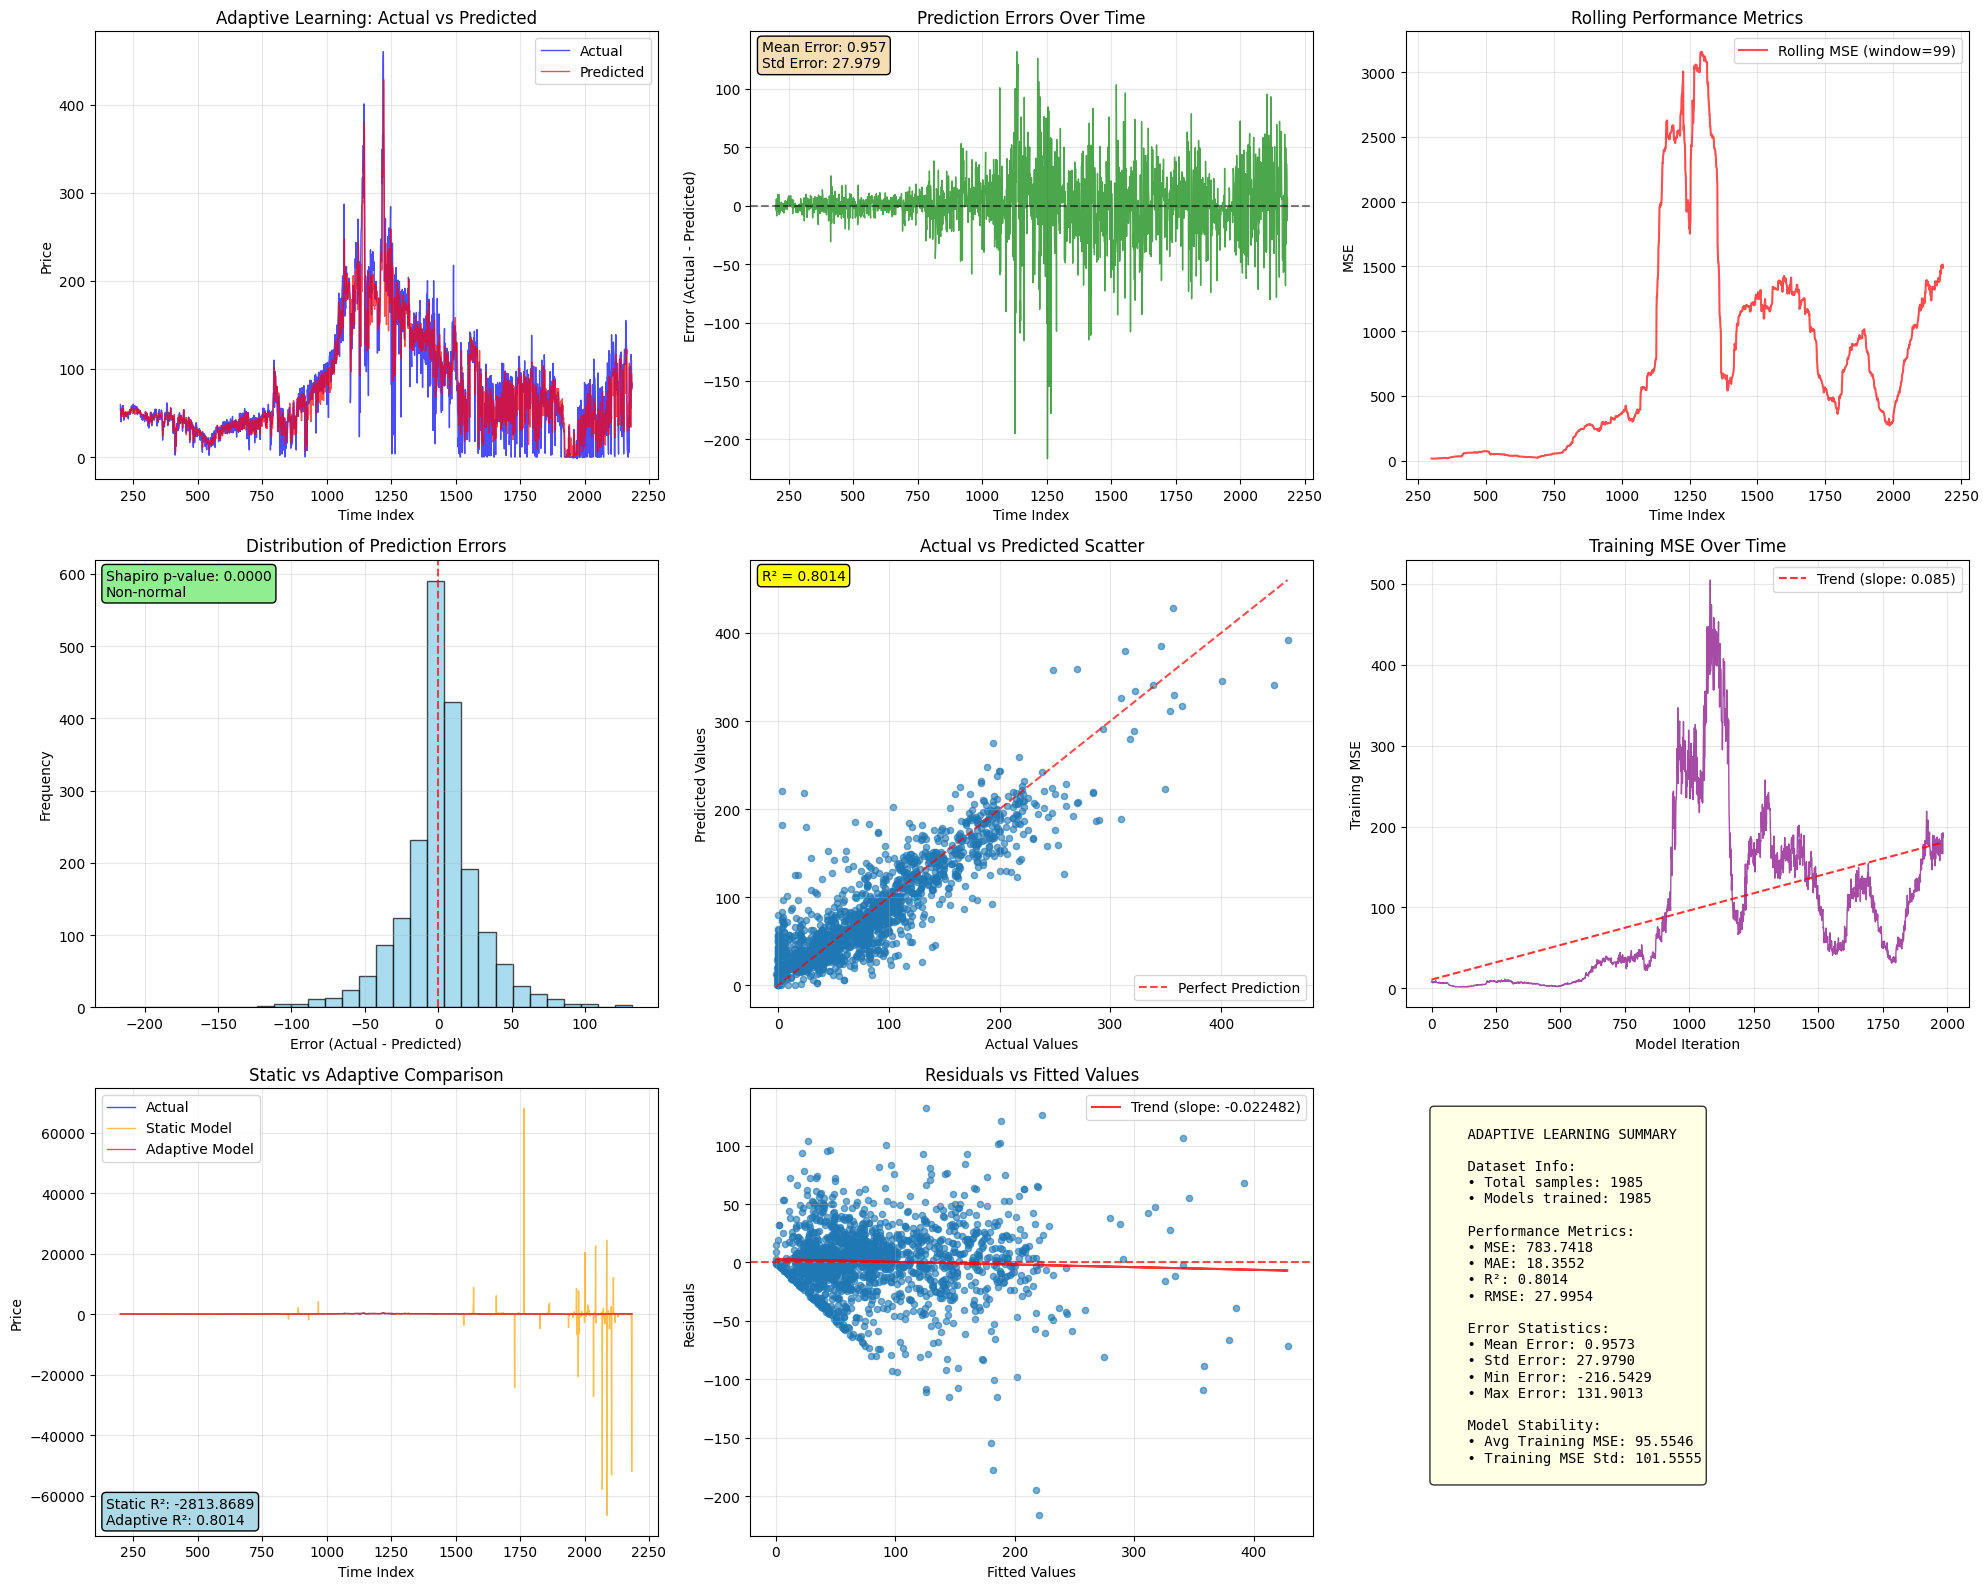


ADAPTIVE LEARNING VALIDATION ANALYSIS

1. PERFORMANCE METRICS:
   MSE: 783.7418
   MAE: 18.3552
   R²:  0.8014
   RMSE: 27.9954

2. ERROR ANALYSIS:
   Mean Error: 0.9573 (should be close to 0)
   Error Std:  27.9790
   Error Range: [-216.54, 131.90]

3. MODEL STABILITY:
   Models Trained: 1985
   Avg Training MSE: 95.5546
   Training MSE Variation: 101.5555

4. VALIDATION CHECKS:
   Error Trend: -0.000224 (should be close to 0)
   Residual Pattern: Good
   ✅ No significant systematic bias detected
   ✅ R² indicates reasonable model performance


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings

def plot_adaptive_learning_results(results, train_subset_df, lag_price_window, 
                                 static_comparison=True, save_plots=False, plot_prefix="adaptive"):
    """
    Create comprehensive plots to validate adaptive learning results.
    
    Parameters:
    -----------
    results : dict
        Results from adaptive_learning_pipeline
    train_subset_df : pandas.DataFrame
        Original training dataset
    lag_price_window : int
        Price feature window used
    static_comparison : bool
        Whether to include static model comparison
    save_plots : bool
        Whether to save plots as files
    plot_prefix : str
        Prefix for saved plot filenames
    """
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 16))
    
    # 1. Actual vs Predicted Time Series
    ax1 = plt.subplot(3, 3, 1)
    predictions = results['predictions']
    actual_values = results['actual_values']
    
    # Create time index for predictions (offset by initial training + price window)
    start_idx = len(train_subset_df) - len(predictions) - lag_price_window
    time_range = range(start_idx, start_idx + len(predictions))
    
    plt.plot(time_range, actual_values, 'b-', label='Actual', alpha=0.7, linewidth=1)
    plt.plot(time_range, predictions, 'r-', label='Predicted', alpha=0.7, linewidth=1)
    plt.title('Adaptive Learning: Actual vs Predicted')
    plt.xlabel('Time Index')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. Prediction Errors Over Time
    ax2 = plt.subplot(3, 3, 2)
    errors = actual_values - predictions
    plt.plot(time_range, errors, 'g-', alpha=0.7, linewidth=1)
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.title('Prediction Errors Over Time')
    plt.xlabel('Time Index')
    plt.ylabel('Error (Actual - Predicted)')
    plt.grid(True, alpha=0.3)
    
    # Add error statistics
    plt.text(0.02, 0.98, f'Mean Error: {np.mean(errors):.3f}\nStd Error: {np.std(errors):.3f}', 
             transform=ax2.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat'))
    
    # 3. Rolling Performance Metrics
    ax3 = plt.subplot(3, 3, 3)
    window_size = max(10, len(predictions) // 20)  # Adaptive window size
    rolling_mse = []
    rolling_mae = []
    rolling_r2 = []
    
    for i in range(window_size, len(predictions)):
        window_actual = actual_values[i-window_size:i]
        window_pred = predictions[i-window_size:i]
        
        rolling_mse.append(mean_squared_error(window_actual, window_pred))
        rolling_mae.append(mean_absolute_error(window_actual, window_pred))
        rolling_r2.append(r2_score(window_actual, window_pred))
    
    rolling_time = time_range[window_size:]
    plt.plot(rolling_time, rolling_mse, 'r-', label=f'Rolling MSE (window={window_size})', alpha=0.7)
    plt.title('Rolling Performance Metrics')
    plt.xlabel('Time Index')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 4. Error Distribution
    ax4 = plt.subplot(3, 3, 4)
    plt.hist(errors, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.7)
    plt.title('Distribution of Prediction Errors')
    plt.xlabel('Error (Actual - Predicted)')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    
    # Add normality info
    from scipy import stats
    _, p_value = stats.shapiro(errors[:min(5000, len(errors))])  # Shapiro-Wilk test (max 5000 samples)
    plt.text(0.02, 0.98, f'Shapiro p-value: {p_value:.4f}\n{"Normal" if p_value > 0.05 else "Non-normal"}', 
             transform=ax4.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen'))
    
    # 5. Actual vs Predicted Scatter Plot
    ax5 = plt.subplot(3, 3, 5)
    plt.scatter(actual_values, predictions, alpha=0.6, s=20)
    
    # Perfect prediction line
    min_val = min(min(actual_values), min(predictions))
    max_val = max(max(actual_values), max(predictions))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7, label='Perfect Prediction')
    
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Scatter')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add R² to plot
    r2_adaptive = r2_score(actual_values, predictions)
    plt.text(0.02, 0.98, f'R² = {r2_adaptive:.4f}', transform=ax5.transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='yellow'))
    
    # 6. Model Training Performance Over Time
    ax6 = plt.subplot(3, 3, 6)
    if results['model_performances']:
        training_performance = results['model_performances']
        plt.plot(range(len(training_performance)), training_performance, 'purple', alpha=0.7, linewidth=1)
        plt.title('Training MSE Over Time')
        plt.xlabel('Model Iteration')
        plt.ylabel('Training MSE')
        plt.grid(True, alpha=0.3)
        
        # Add trend line
        z = np.polyfit(range(len(training_performance)), training_performance, 1)
        p = np.poly1d(z)
        plt.plot(range(len(training_performance)), p(range(len(training_performance))), 
                "r--", alpha=0.8, label=f'Trend (slope: {z[0]:.3f})')
        plt.legend()
    
    # 7. Static vs Adaptive Comparison (if available)
    if static_comparison:
        ax7 = plt.subplot(3, 3, 7)
        
        # Run static comparison
        from utils.matrix_builder import create_ta_feature_matrix
        X_static, y_static = create_ta_feature_matrix(train_subset_df, lag_price_window)
        
        # Use same split as adaptive (approximately)
        split_point = len(X_static) - len(predictions)
        X_train_static = X_static.iloc[:split_point]
        X_test_static = X_static.iloc[split_point:]
        y_train_static = y_static.iloc[:split_point]
        y_test_static = y_static.iloc[split_point:]
        
        # Train static model with better parameters to avoid convergence issues
        lasso_static = Lasso(alpha=0.1, max_iter=2000, tol=1e-4)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            lasso_static.fit(X_train_static, y_train_static)
        
        y_pred_static = lasso_static.predict(X_test_static)
        
        # Plot comparison
        comparison_time = time_range[:len(y_test_static)]
        plt.plot(comparison_time, y_test_static.values, 'b-', label='Actual', alpha=0.7, linewidth=1)
        plt.plot(comparison_time, y_pred_static, 'orange', label='Static Model', alpha=0.7, linewidth=1)
        plt.plot(comparison_time, predictions[:len(y_pred_static)], 'r-', label='Adaptive Model', alpha=0.7, linewidth=1)
        
        plt.title('Static vs Adaptive Comparison')
        plt.xlabel('Time Index')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Performance comparison in text box
        static_r2 = r2_score(y_test_static, y_pred_static)
        adaptive_r2 = r2_score(y_test_static.values, predictions[:len(y_pred_static)])
        
        plt.text(0.02, 0.02, f'Static R²: {static_r2:.4f}\nAdaptive R²: {adaptive_r2:.4f}', 
                 transform=ax7.transAxes, verticalalignment='bottom', 
                 bbox=dict(boxstyle='round', facecolor='lightblue'))
    
    # 8. Residuals vs Fitted
    ax8 = plt.subplot(3, 3, 8)
    plt.scatter(predictions, errors, alpha=0.6, s=20)
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Fitted Values')
    plt.grid(True, alpha=0.3)
    
    # Add trend line for residuals
    z = np.polyfit(predictions, errors, 1)
    p = np.poly1d(z)
    plt.plot(predictions, p(predictions), "r-", alpha=0.8, 
             label=f'Trend (slope: {z[0]:.6f})')
    plt.legend()
    
    # 9. Performance Summary
    ax9 = plt.subplot(3, 3, 9)
    ax9.axis('off')
    
    # Summary statistics
    summary_text = f"""
    ADAPTIVE LEARNING SUMMARY
    
    Dataset Info:
    • Total samples: {len(predictions)}
    • Models trained: {results['n_models_trained']}
    
    Performance Metrics:
    • MSE: {results['overall_mse']:.4f}
    • MAE: {results['overall_mae']:.4f}
    • R²: {results['overall_r2']:.4f}
    • RMSE: {np.sqrt(results['overall_mse']):.4f}
    
    Error Statistics:
    • Mean Error: {np.mean(errors):.4f}
    • Std Error: {np.std(errors):.4f}
    • Min Error: {np.min(errors):.4f}
    • Max Error: {np.max(errors):.4f}
    
    Model Stability:
    • Avg Training MSE: {np.mean(results['model_performances']):.4f}
    • Training MSE Std: {np.std(results['model_performances']):.4f}
    """
    
    ax9.text(0.05, 0.95, summary_text, transform=ax9.transAxes, fontsize=10,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    
    plt.tight_layout()
    
    if save_plots:
        plt.savefig(f'{plot_prefix}_comprehensive_analysis.png', dpi=300, bbox_inches='tight')
        print(f"Plot saved as {plot_prefix}_comprehensive_analysis.png")
    
    plt.show()
    
    # Print detailed analysis
    print("\n" + "="*60)
    print("ADAPTIVE LEARNING VALIDATION ANALYSIS")
    print("="*60)
    
    print(f"\n1. PERFORMANCE METRICS:")
    print(f"   MSE: {results['overall_mse']:.4f}")
    print(f"   MAE: {results['overall_mae']:.4f}")
    print(f"   R²:  {results['overall_r2']:.4f}")
    print(f"   RMSE: {np.sqrt(results['overall_mse']):.4f}")
    
    print(f"\n2. ERROR ANALYSIS:")
    print(f"   Mean Error: {np.mean(errors):.4f} (should be close to 0)")
    print(f"   Error Std:  {np.std(errors):.4f}")
    print(f"   Error Range: [{np.min(errors):.2f}, {np.max(errors):.2f}]")
    
    print(f"\n3. MODEL STABILITY:")
    print(f"   Models Trained: {results['n_models_trained']}")
    print(f"   Avg Training MSE: {np.mean(results['model_performances']):.4f}")
    print(f"   Training MSE Variation: {np.std(results['model_performances']):.4f}")
    
    print(f"\n4. VALIDATION CHECKS:")
    error_trend = np.polyfit(range(len(errors)), errors, 1)[0]
    print(f"   Error Trend: {error_trend:.6f} (should be close to 0)")
    print(f"   Residual Pattern: {'Good' if abs(error_trend) < 0.001 else 'Check for bias'}")
    
    if abs(np.mean(errors)) > np.std(errors) * 0.1:
        print("   ⚠️  WARNING: Systematic bias detected in predictions")
    else:
        print("   ✅ No significant systematic bias detected")
    
    if results['overall_r2'] < 0:
        print("   ⚠️  WARNING: R² is negative - model performs worse than mean prediction")
    elif results['overall_r2'] < 0.3:
        print("   ⚠️  WARNING: Low R² suggests poor model fit")
    else:
        print("   ✅ R² indicates reasonable model performance")

# Usage example:
plot_adaptive_learning_results(results, train_subset_df, lag_price_window, 
                               static_comparison=True, save_plots=True)